
Lab 5 - LSTM for Text Classification


1. Getting the Dataset




In [0]:
import keras
imdb = keras.datasets.imdb

loading only the top 10000 words in the vocabulary like you did last week

In [0]:
VOCAB_SIZE = 10000

we reserve indices 0 for ‘<PAD ’, 1 for ‘<START’ and 2 for ‘<UNK’ i.e. words not in vocabulary

In [0]:
INDEX_FROM = 3 # EDITED


In [0]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=INDEX_FROM)

Sanity check:

Each instance in the training data is a list of word indices representing the words in the review

In [150]:
print('Sample review:', train_data[0])


Sample review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


and each label is 1 if that review is positive, else 0

In [151]:
print('\n Sample label:', test_labels[1])


 Sample label: 1


##2. Readying the Inputs for the LSTM
The movie reviews are of different lengths. Last week, the vectors for all the words in a given
review were averaged so that each input to the neural network was an EMBED_SIZE vector. The
LSTM can handle sequence data by taking input in the sequence in turn i.e. taking one review at a
time. The standard is to feed it same sized inputs i.e. reviews of the same length. This is achieved by
padding or truncating each review as needed to MAXIMUM_LENGTH. Keras provides a way to do
this.

Using pad_sequences from keras.preprocessing.sequence, pad the train and test data.

In [0]:
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 500

Sanity Check

In [153]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))

word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

train_data_after = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=MAXIMUM_LENGTH)

print('Length of sample train_data after preprocessing:', len(train_data_after[0]))

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500


##3. Building the Model
In this section, you will use the keras Sequential or Model API to build a model

In [154]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

EMBED_SIZE = 100  #FIXED 
units = 100

InputLayer = Input(shape=(MAXIMUM_LENGTH,), dtype='int32')
Embed = Embedding(VOCAB_SIZE , EMBED_SIZE, input_length=MAXIMUM_LENGTH)(InputLayer)
LSTM = LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True)(Embed)
dense = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform')(LSTM)
model = Model(inputs=[InputLayer], outputs=[dense])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


Visualizing the model Structure


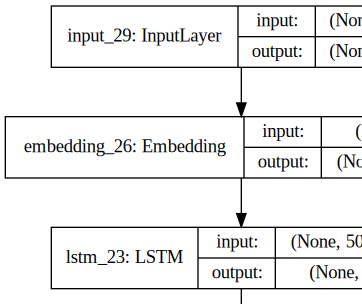

In [155]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#4. Training the Model
First, split the training data into training and validation data. You can use 2000 samples for
validation and the rest for training.

Then, using this split dataset and the model.fit() function, train the model for 3 epochs with a batch
size of 100. Using model.fit().history, plot the training and validation accuracy across the epochs.
Your output should look like this.


In [0]:
import numpy as np 
import matplotlib.pyplot as plt


BATCH_SIZE =100
EPOCHS =3

train_val = np.array(train_data_after[:2000])
train_d = np.array(train_data_after[2000:])

label_val = np.array(train_labels[:2000])
train_l = np.array(train_labels[2000:])


In [0]:
#History

history = model.fit(train_d, train_l, epochs=EPOCHS , batch_size=BATCH_SIZE,validation_data=(train_val, label_val))


Using model.fit().history, plot the training and validation accuracy across the epochs

In [0]:
# PLot using model.fir().history
def plot(history):
  history_dict = history.history
  #print(history_dict.keys())

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

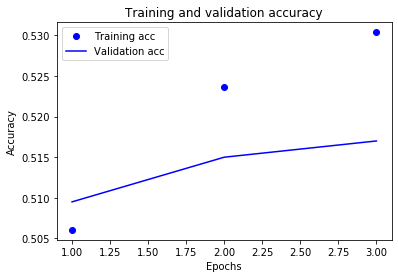

In [161]:
plot(history)

##5. Evaluating the Model on the Test Data

Evaluate the model on the preprocessed test data. Print the test loss and accuracy using the line of
code below

In [115]:
test_data_after = keras.preprocessing.sequence.pad_sequences(test_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=MAXIMUM_LENGTH)


results = model.evaluate(test_data_after, test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

25000/25000 [==============================] - 95s 4ms/step
test_loss: 0.696229334564209 test_accuracy: 0.5118


#6. Extracting the Word Embeddings
Extract the word embeddings from the embedding layer model using
model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0]
where the layer number depends on the order in which the layers were added to the model. You
can get details about the order from model.summary() or by calling model.layers.


In [116]:
word_embeddings = model.layers[1].get_weights()[0]

print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


#7. Visualizing the Reviews
In this section, we will view the effects of preprocessing on the dataset. Keras already preprocessed
the dataset. In this preprocessed dataset, all the words have already been mapped to indices and
were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent
word in the dataset, and so on.

In [125]:
# Reset Data
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=INDEX_FROM)

word2idx = imdb.get_word_index()
# 9998 since we only used top 1000 words of including ‘<PAD>’, ‘<START>’ and ‘<UNK>’
word2idx = {k:(v+INDEX_FROM) for k,v in word2idx.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

# In the next line, create the idx2word map for all the words in the dataset
idx2word = {}
for key, value in word2idx.items():
  idx2word[value] = key

# View a sample review text using the lines of code below
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

view the corresponding data

In [126]:
print(train_data[0])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


8. Visualizing the Word_Embeddings
Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3.


In [127]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2   ...        97        98        99
woods      0.014584 -0.023229  0.034505  ...  0.002564  0.000413  0.003026
hanging    0.012257  0.003929 -0.023911  ... -0.016317  0.021681  0.031446
woody     -0.035216 -0.006086  0.008985  ...  0.037916 -0.020993 -0.029235
arranged  -0.010463 -0.001388 -0.017231  ...  0.009159  0.007215 -0.019347
bringing   0.002758  0.011330 -0.013720  ...  0.067569  0.038217 -0.034302
wooden     0.050368  0.021010  0.008729  ... -0.010500 -0.061428  0.087212
errors     0.007921  0.031989 -0.049887  ... -0.006778 -0.029282  0.007567
dialogs    0.041077 -0.051241 -0.038249  ... -0.007028  0.033451 -0.033306
kids      -0.064942  0.010439 -0.026839  ...  0.040594 -0.006789 -0.016402
uplifting  0.079436  0.018429 -0.024320  ... -0.046516 -0.056419  0.075209

[10 rows x 100 columns]


Plot the word embeddings using TSNE

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)

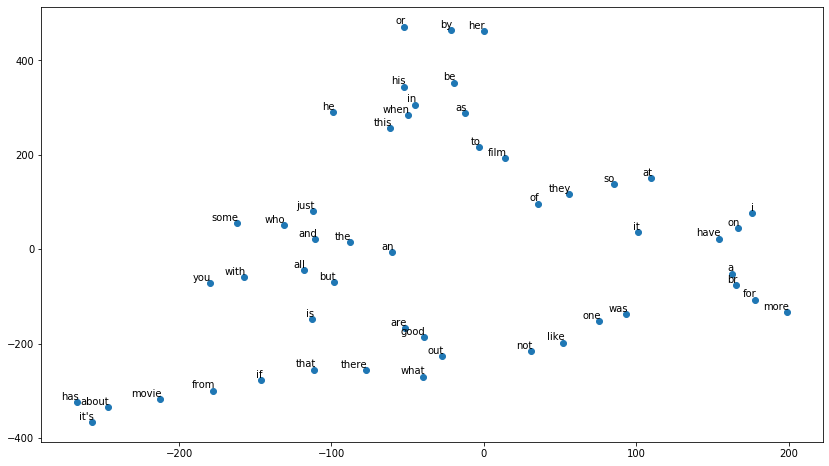

In [130]:
# starting from the first word
start = 3
plot_only = 54
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i+1] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',va='bottom')

**NOTE: Index pos for train_data[0] is shifted for +1 in the output when compared to the expected output in document.**

**Hence, the above code block has index set to 'i+1'.**

#**9. Questions**

1. Create a new model that is a copy of the model step 3. To this new model, add two dropout
layers, one between the embedding layer and the LSTM layer and another between the
LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?
How about if you train this new model for 6 epochs instead?


In [158]:
# NEW MODEL ...... THIS CAN BE TREATED AS STEP 3 for this Question
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dropout

EMBED_SIZE = 100  #FIXED 
units = 100

InputLayer = Input(shape=(MAXIMUM_LENGTH,), dtype='int32')
Embed = Embedding(VOCAB_SIZE , EMBED_SIZE, input_length=MAXIMUM_LENGTH)(InputLayer)
Dropout1 = Dropout(0.2)(Embed)
LSTM = LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True)(Dropout1)
Dropout2 = Dropout(0.2)(LSTM)
dense = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform')(Dropout2)
NewModel = Model(inputs=[InputLayer], outputs=[dense])

NewModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(NewModel.summary())

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
________________________________________________

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 224s 10ms/step - loss: 0.6428 - acc: 0.5362 - val_loss: 0.7269 - val_acc: 0.5095
Epoch 2/3
23000/23000 [==============================] - 224s 10ms/step - loss: 0.6362 - acc: 0.5485 - val_loss: 0.7406 - val_acc: 0.5175
Epoch 3/3
23000/23000 [==============================] - 225s 10ms/step - loss: 0.6355 - acc: 0.5485 - val_loss: 0.7305 - val_acc: 0.5190


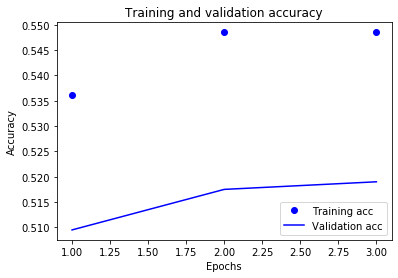

In [162]:
# EPOCHS = 3
EPOCHS =3

history1 = model.fit(train_d, train_l, epochs=EPOCHS , batch_size=BATCH_SIZE,validation_data=(train_val, label_val))
plot(history1)

Train on 23000 samples, validate on 2000 samples
Epoch 1/6
23000/23000 [==============================] - 224s 10ms/step - loss: 0.6350 - acc: 0.5457 - val_loss: 0.7420 - val_acc: 0.5150
Epoch 2/6
23000/23000 [==============================] - 224s 10ms/step - loss: 0.6255 - acc: 0.5774 - val_loss: 0.7407 - val_acc: 0.5135
Epoch 3/6
23000/23000 [==============================] - 223s 10ms/step - loss: 0.5811 - acc: 0.6878 - val_loss: 0.7524 - val_acc: 0.5025
Epoch 4/6
23000/23000 [==============================] - 223s 10ms/step - loss: 0.5722 - acc: 0.6883 - val_loss: 0.6957 - val_acc: 0.6925
Epoch 5/6
23000/23000 [==============================] - 225s 10ms/step - loss: 0.5712 - acc: 0.7019 - val_loss: 0.7224 - val_acc: 0.5010
Epoch 6/6
23000/23000 [==============================] - 223s 10ms/step - loss: 0.6386 - acc: 0.5485 - val_loss: 0.7538 - val_acc: 0.5140


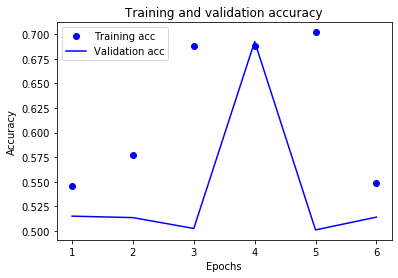

In [163]:
#EPOCHS=6

EPOCHS= 6 
history2 = model.fit(train_d, train_l, epochs=EPOCHS , batch_size=BATCH_SIZE,validation_data=(train_val, label_val))
plot(history2)

2. Experiment with compiling the model with batch sizes of 1, 32, len(training_data). What do
you observe?


---------------------BATCH_SIZE =1-------------------------
Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 6134s 267ms/step - loss: 0.6310 - acc: 0.6135 - val_loss: 0.4664 - val_acc: 0.8080
Epoch 2/3
23000/23000 [==============================] - 6135s 267ms/step - loss: 0.3343 - acc: 0.8657 - val_loss: 0.2975 - val_acc: 0.8815
Epoch 3/3
23000/23000 [==============================] - 6137s 267ms/step - loss: 0.1991 - acc: 0.9266 - val_loss: 0.2653 - val_acc: 0.8845


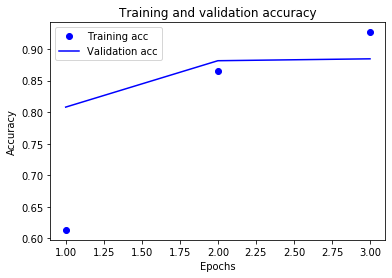

---------------------BATCH_SIZE =32-------------------------
Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 418s 18ms/step - loss: 0.1179 - acc: 0.9607 - val_loss: 0.2634 - val_acc: 0.9010
Epoch 2/3
23000/23000 [==============================] - 415s 18ms/step - loss: 0.0896 - acc: 0.9711 - val_loss: 0.2689 - val_acc: 0.9045
Epoch 3/3
23000/23000 [==============================] - 413s 18ms/step - loss: 0.0688 - acc: 0.9789 - val_loss: 0.2912 - val_acc: 0.8990


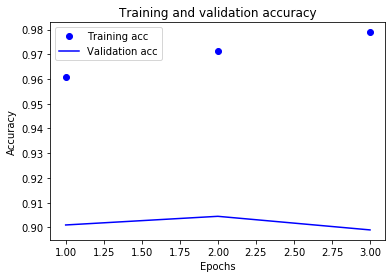

---------------BATCH_SIZE = len(train_data)------------------
Train on 23000 samples, validate on 2000 samples
Epoch 1/3


In [0]:
# BATCH_SIZE =1
print('---------------------BATCH_SIZE =1-------------------------')
history2_1 = model.fit(train_d, train_l, epochs=3 , batch_size=1,validation_data=(train_val, label_val))
plot(history2_1)
# BATCH_SIZE = 32
print('---------------------BATCH_SIZE =32-------------------------')
history2_2 = model.fit(train_d, train_l, epochs=3 , batch_size=32,validation_data=(train_val, label_val))
plot(history2_2)
# BATCH_SIZE = len(train_data)
print('---------------BATCH_SIZE = len(train_data)------------------')
history2_3 = model.fit(train_d, train_l, epochs=3 , batch_size=len(train_data),validation_data=(train_val, label_val))
plot(history2_3)